# Advanced Machine Learning

### Assigment 8 - Reinforcement Learning

**Team:**
    João Raimundo (57454), Rui Roque (57588)

### 0.1. Import Packages

In [4]:
from datetime import datetime
import random
import gym
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# random seed
np.random.seed(42)
random.seed(42)

# Problem 1 -- Mountain Car Problem

In this assigment we train an agent to become proficient at solving the Mountain Car Problem.

We will be using standard numpy to implement Q-Learning, and the environment provided by the OpenAI Gym (https://gym.openai.com/) framework.

You can read a brief explanation of the environment here: https://gym.openai.com/envs/MountainCar-v0/. To really understand how it works in detail, you can take a look at its source code here: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py.



In [5]:
# "Make" the environment, as in, instantiate an object with an environment of the Mountain Car Problem.
env = gym.make("MountainCar-v0")

The attribute `observation_space` stores the information of the shape (and contents) of the observation space. In this instance, it is a Box, meaning the observations are a cartesian product of the intervals of each dimension.

For the mountain car problem, the first dimension is the current position (in the x-axis) of the car, which can take up values from -1.2 to 0.6. And the second dimension is the current velocity of the car, whose values range from -0.07 to 0.07.

In [6]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

The following example illustrates how we can obtain the lower and upper bounds of the observation space for a given dimension. In this instance, it is dimension 0 (first).

In [7]:
print("Lower bound for first dimension:", env.observation_space.low[0])
print("Upper bound for first dimension:", env.observation_space.high[0])

Lower bound for first dimension: -1.2
Upper bound for first dimension: 0.6


The attribute `action_space` stores the information of the shape (and contents) of the action space. In this instance, it is a discrete space with dimension 3, meaning it can take up 3 values.

For the mountain car problem, action 0 means accelerate left, 1 means do not accelerate, and 2 means accelerate right.

In [8]:
env.action_space

Discrete(3)

### 1.1. Q-Learning

Q-Learning is a reinforcement learning algorithm to learn the expected cost, or reward, of the action of an agent acting on an environment with a particular observed state. In the Moutain Problem, a state is a (position, velocity) pair.

In practical terms, the expected costs or rewards are stored in what is called a Q-Table, where for a value is attributed to each state and possible actions within that state.

The agent explores the environment and receives rewards for its actions, which can then be used to estimate future rewards. In this environment, for each action the agent takes, it is awarded -1 if it is not at the objective, and 0 if it is.

At each step, the agent does one of two things: a random action, which would be an exploration strategy; or it chooses the action which minimizes cost or maximizes reward (according to its Q-Table), exploiting its knowledge.

The Mountain Car problem has bounded continuous observation space. If one were to build a Q-Table from the cartesian product of the observation dimensions, it would be virtually infinite as the position and velocity are continuous. However, as it is a bounded space, we can discretize it in order to build a Q-Table that is more tractable.

A simple way to discretize them is the following: convert to decimals by multiplying position by 10 and velocity by 100 and rounding it to the nearest integer. Shift it to start to 0 by adding the absolute value of the minimum value.

E.g. position is bounded by the interval [-1.2, 0.6], if we discretize this space by transforming to ints, we get 3 possible positions: -1, 0 and 1. If we multiply by 10 to get to the dozens, we have a position from [-12 to 6], meaning we get 19 possible positions, which allows for higher precision.

We do the same for the velocity, but by multiplying by 100 as it is bounded by [-0.07, 0.07].

In [9]:
num_pos = np.round(env.observation_space.high[0] * 10 - env.observation_space.low[0] * 10).astype("int") + 1
print(f"Discretized position observation space: {num_pos}")
num_vel = np.round(env.observation_space.high[1] * 100 - env.observation_space.low[1] * 100).astype("int") + 1
print(f"Discretized velocity observation space: {num_vel}")
print(f"Total states: {num_pos * num_vel * env.action_space.n}")

Discretized position observation space: 19
Discretized velocity observation space: 15
Total states: 855


This helper function translates the original observation space to our discretized space. First we need to scale the position by multiplying by 10 and velocity by 100, and then shift them to start at 0.

To do this, we just need to sum the absolute value of the lower bound!

We can then use these values to index the Q-Table.

In [15]:
def get_state_from_observation(env, observation):
    pos, vel = observation
    pos = np.round((pos * 10 + abs(env.observation_space.low[0] * 10))).astype("int")
    vel = np.round((vel * 100 + abs(env.observation_space.low[1] * 100))).astype("int")
    return pos, vel

We initialize the Q-table filling it with zeros. The matrix shape have the next configuration: `(number of positions, number of velocities, number of actions)`.

In [11]:
#(19,15,3) q-table shape
def init_qtable(env):
    qtable = np.zeros((19,15,3))  # fill with zeros
    return qtable

In [12]:
qtable = init_qtable(env)
qtable.shape

(19, 15, 3)

Set parameter values

In [16]:
NUM_EPISODES = 10000 
STEPS_PER_EPISODE = 1000 
ALPHA = 1
BETA = 1
GAMMA = 0.9
EPSILON_INIT = 1.0
MIN_EPSILON = 0.05
LEARNING_RATE = 0.1 #0.2

We implement the q-learning algorithm with 10000 episodes and 1000 steps per episode.

In [14]:
env._max_episode_steps = STEPS_PER_EPISODE

Implement the Q-Learning algorithm in the train loop.

In [14]:
rewards = []

with tqdm(total=NUM_EPISODES, position=0, leave=True) as pbar:
    epsilon = EPSILON_INIT
    for i_episode in range(NUM_EPISODES):
        observation = env.reset()
        pos, vel = get_state_from_observation(env, observation)
        total_rewards = 0.0

        for t in range(STEPS_PER_EPISODE):
            # implemented action
            if(np.random.random() < 1 - epsilon):
                action = np.argmax(qtable[pos, vel])
            else:
                action = np.random.randint(0, env.action_space.n)

            # Take a step in the environment
            observation, reward, done, info = env.step(action)
            # Get new states from new observation
            new_pos, new_vel = get_state_from_observation(env, observation)

            # Implemented q-table update
            if(done and observation[0] >= 0.5):
                qtable[pos, vel, action] = reward
            else:
                qtable[pos, vel, action] = qtable[pos, vel, action] + LEARNING_RATE*(reward + GAMMA*np.max(qtable[new_pos, new_vel, action]) - qtable[pos, vel, action])

            pos, vel = new_pos, new_vel
            total_rewards += reward

            if done:
                break
        
        # Epsilon Decay
        epsilon = (EPSILON_INIT - MIN_EPSILON) * max((NUM_EPISODES - i_episode) / NUM_EPISODES, 0) + MIN_EPSILON

        rewards.append(total_rewards)
        pbar.update(1)
        pbar.set_postfix({"Mean Rewards (last 100)": np.mean(rewards[-100:]), "Latest Reward": total_rewards, "epsilon": epsilon})

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving Q-table and Rewards:

In [ ]:
now = datetime.now().isoformat()
np.save(f"qtable.npy", qtable)
np.save(f"rewards.npy", np.array(rewards))

Loading Q-table and Rewards:

In [18]:
qtable = np.load("qtable.npy")
rewards = np.load("rewards.npy")

Plotting Results - Episodes Vs. Rewards

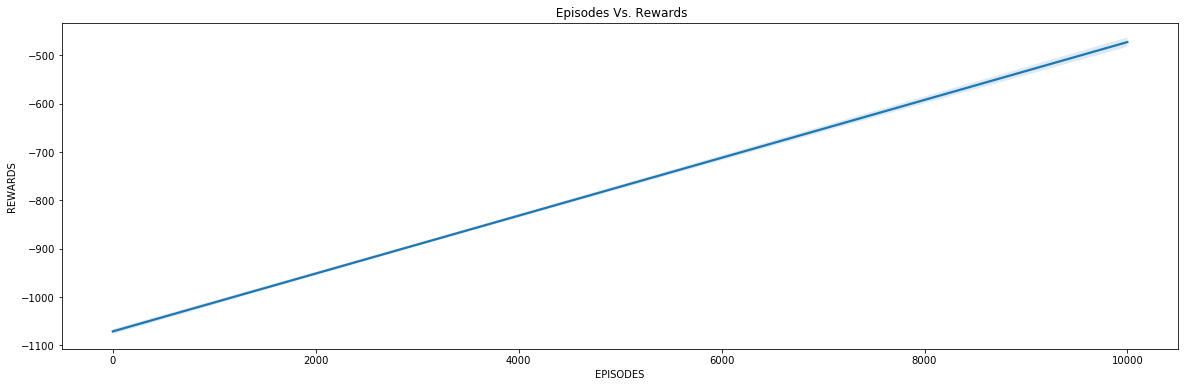

In [19]:
# linear regression plot
plt.figure(figsize=(20, 6))
reg_plot = sns.regplot(x=list(range(len(rewards))), y=rewards, scatter=False)
reg_plot.set(xlabel='EPISODES', ylabel='REWARDS', title = ' Episodes Vs. Rewards')
plt.show()

Throught the learning process, the value of rewards increases.

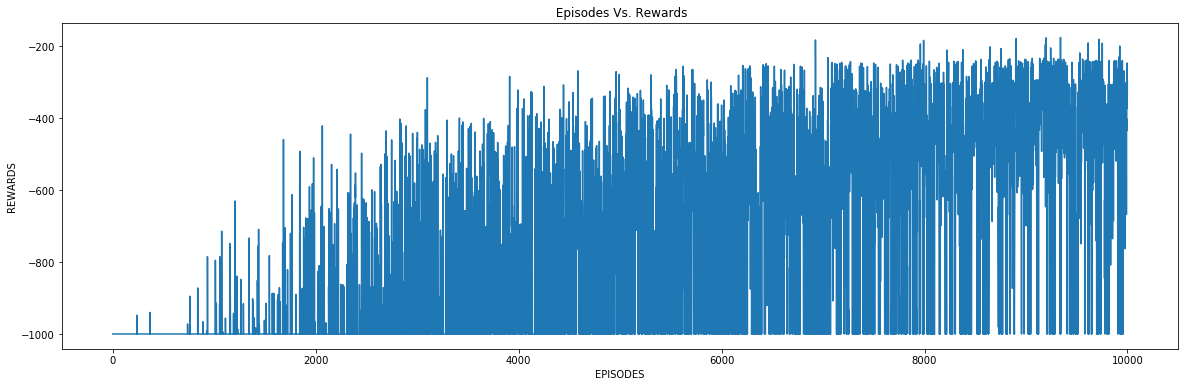

In [20]:
# line plot
plt.figure(figsize=(20, 6))
line_plot = sns.lineplot(x=list(range(len(rewards))), y=rewards)
line_plot.set(xlabel='EPISODES', ylabel='REWARDS', title = ' Episodes Vs. Rewards')
plt.show()

The value of reward increases during the learning process by episodes. After the 7000 episode, it seems that the changes are minimal.

### Recording the video

Saving the video as MP4

In [21]:
RECORD = True

observation = env.reset()
pos, vel = get_state_from_observation(env, observation)
if RECORD:
    recorder = VideoRecorder(env, "q-learning.mp4") 
for t in range(STEPS_PER_EPISODE):
    env.render()
    if RECORD:
        recorder.capture_frame()
    action = np.argmax(qtable[pos, vel])
    observation, reward, done, info = env.step(action)

    pos, vel = get_state_from_observation(env, observation)

    if done:
        break

/home/redck/.local/lib/python3.8/site-packages/gym/wrappers/monitoring/video_recorder.py:421: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


In [22]:
recorder.close()
env.close()

## Problem 2


<img src="problem2.JPG" width="600" height="440">

**Response:**
<p>

Given the observation and action spaces: <p>

 * The action space comprises four discrete actions. 
 
 * The observation space `(-infinite, +infinite, (8,))`, tell us that the state represents a 8-dimentional box, so each state observation is a vector (float) values. Which is a infinity space.

In Q-learning (and in general value based reinforcement learning) we are typically interested in learning a Q-function, Q(s,a). 

For tabular Q-learning, where we have a finite state and action space we can maintain a table lookup that maintains our current estimate of the Q-value. However, When we have an infinite state space it might not be manageable to maintain a separate Q-function for each state-action pair - it becomes impossible to use a table - and so we need to use function approximation to generalise across states. This is typically done using a deep neural network with the Q-learning algorithm (DQN) due to their expressive power.